# Modelos de IA para previsão de notas acadêmicas

Com base em um conjunto de dados de notas acadêmicas, vamos criar modelos de aprendizado de máquina para prever as notas dos alunos e alertar sobre riscos de possíveis dificultades como prova final e reprovações.

## 1. Tratamento dos Dados

Primeiramente, precisamos adaptar os dados para o formato adequado para o treinamento dos modelos. No conjunto de dados `notas.csv`, Nos interessamos apenas nas colunas `AlunoID` que corresponde ao identificador do aluno (precisamos ter seu perfil salvo para melhor análise da IA), `Disciplina` que é a disciplina em questão e as colunas `Unidade X` sendo X o número da unidade.


Vamos começar importando as bibliotecas, abrir o CSV e convertendo as notas pra float:


In [58]:
import pandas as pd


# Carrega os dados do arquivo CSV
notas = pd.read_csv('dados/notas.csv')

# Converter as colunas de notas para o tipo float
for unidade in ['Unidade 1', 'Unidade 2', 'Unidade 3', 'Unidade 4', 'Unidade 5']:
    notas[unidade] = notas[unidade].str.replace(',', '.').astype(float)

Após isso, vamos criar uma coluna `Media` que será a média das notas de cada aluno em cada disciplina. Não vamos considerar a nota da prova final para o cálculo da média, pois ela é uma nota de recuperação e vamos considerar apenas as unidades que tenham notas pois, se estiver em branco, significa que a disciplina não tem nota naquela unidade.


In [59]:
# Calcular a média das notas, sem prova final
notas['Media'] = notas[['Unidade 1', 'Unidade 2', 'Unidade 3', 'Unidade 4', 'Unidade 5']].mean(axis=1, skipna=True)


Com a coluna `Media` criada, agora podemos pivotear os dados. `AlunoID` será o índice, `Disciplina` será as colunas e as notas serão os valores. Isso nos dará um DataFrame onde cada linha representa um aluno e cada coluna uma disciplina, com as notas correspondentes. Um aluno pode ter cursado uma disciplina mais de uma vez em caso de reprovação, por isso pode gerar conflitos no pivotamento. Para resolver isso, vamos usar a menor nota, pois é a nota que o aluno pode ter reprovado/ficado de prova final.


In [60]:
notas_pivoteadas = notas.pivot_table(
    index='AlunoID',
    columns='Disciplina',
    values='Media',
    aggfunc='min'
)

O resultado ficando assim:


In [61]:
notas_pivoteadas.head()

Disciplina,ARQUITETURA DE COMPUTADORES,BANCO DE DADOS,BANCOS DE DADOS RELACIONAIS,CIRCUITOS DIGITAIS,COMPILADORES,COMPUTAÇÃO GRÁFICA,CÁLCULO DIFERENCIAL E INTEGRAL I,CÁLCULO DIFERENCIAL E INTEGRAL II,ELETRICIDADE E MAGNETISMO,EMPREENDEDORISMO,...,TRABLO DE CONCLUSÃO DE CURSO II - TCC II,TÓPICOS EM ARQUITETURA DE COMPUTADORES,TÓPICOS EM BIOINFORMÁTICA,TÓPICOS EM COMPUTAÇÃO APLICADA,TÓPICOS EM ENGENHARIA DE SOFTWARE,TÓPICOS EM PROGRAMAÇÃO,TÓPICOS EM REDES DE COMPUTADORES,TÓPICOS EM SISTEMAS COMPUTACIONAIS,VISÃO COMPUTACIONAL,ÁLGEBRA LINEAR
AlunoID,,,,,,,,,,,,,,,,,,,,,
1,2.333333,9.666667,NaN,9.033333,7.333333,8.333333,9.333333,9.266667,8.333333,NaN,...,NaN,NaN,8.333333,NaN,8.633333,NaN,NaN,NaN,NaN,7.500000
2,7.066667,9.166667,8.500000,8.533333,7.033333,7.166667,7.100000,6.233333,NaN,NaN,...,NaN,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,8.433333,7.000000
3,7.000000,9.833333,9.333333,7.500000,7.266667,8.700000,6.333333,8.133333,NaN,9.066667,...,NaN,7.0,5.100000,8.566667,8.333333,NaN,9.866667,NaN,NaN,8.266667
4,7.466667,8.666667,7.100000,7.433333,7.100000,6.433333,8.633333,7.466667,NaN,NaN,...,NaN,NaN,10.000000,NaN,7.866667,6.200000,9.966667,NaN,6.500000,2.500000
5,NaN,NaN,NaN,9.933333,7.866667,5.666667,8.766667,NaN,NaN,NaN,...,NaN,5.4,6.400000,NaN,8.366667,6.666667,NaN,NaN,6.433333,NaN


Agora, vamos salvar o DataFrame resultante em um arquivo CSV.


In [62]:
notas_pivoteadas.to_csv('dados/notas_pivoteadas.csv', index=False)

## 2. Treinamenro do Modelo

O modelo escolhido para prever as notas foi o Random Forest Regressor pois:
- O problema é de regressão, já que estamos prevendo notas (valores contínuos);
- A relação entre disciplinas não é linear, o que torna o Linear Regression inadequado;
- O Random Forest é robusto para overfitting e lida bem com dados não lineares;
- A saida do modelo é mais de uma nota, ou seja, multioutput.

Primeiramente, vamos importar as bibliotecas necessárias.

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error

Agora vamos criar listas com os nomes das disciplinas que iremos utilizar para treinar o modelo. Vamos considerar apenas as disciplinas obrigatórias. Ficaram de fora: TCC 1 e 2, pois o método de avaliação é diferente e estágio, pois não é uma disciplina de conhecimento técnico;

In [64]:
P1 = [
    'PROGRAMAÇÃO ESTRUTURADA',
    'INTRODUÇÃO À LÓGICA',
    'INGLÊS TÉCNICO E CIENTÍFICO',
    'INFORMÁTICA E SOCIEDADE',
    'CÁLCULO DIFERENCIAL E INTEGRAL I',
    'INTRODUÇÃO À METODOLOGIA CIENTÍFICA'
]
P2 = [
    'CÁLCULO DIFERENCIAL E INTEGRAL II',
    'CIRCUITOS DIGITAIS',
    'ESTRUTURAS DE DADOS',
    'LABORATÓRIO DE PROGRAMAÇÃO',
    'MATEMÁTICA DISCRETA',
    'PROGRAMAÇÃO ORIENTADA A OBJETOS'
]
P3 = [
    'ÁLGEBRA LINEAR',
    'ARQUITETURA DE COMPUTADORES',
    'PROBABILIDADE E ESTATÍSTICA',
    'BANCO DE DADOS',
    'INTERFACE HUMANO COMPUTADOR',
    'PROCESSAMENTO DIGITAL DE IMAGENS'
]
P4 = [
    "COMPUTAÇÃO GRÁFICA",
    "SISTEMAS OPERACIONAIS",
    "PROGRAMAÇÃO LINEAR",
    "REDES DE COMPUTADORES",
    "PROJETO E ANÁLISE DE ALGORITMOS",
    "PROCESSAMENTO DIGITAL DE IMAGENS"
]
P5 = [
    "SISTEMAS DISTRIBUÍDOS",
    "TEORIA DA COMPUTAÇÃO",
    "ENGENHARIA DE SOFTWARE I",
    "SEGURANÇA EM SISTEMAS",
    "INTELIGÊNCIA ARTIFICIAL"
]
P6 = [
    "COMPILADORES",
    "LINGUAGENS DE PROGRAMAÇÃO",
    "ENGENHARIA DE SOFTWARE II",
    "BANCOS DE DADOS RELACIONAIS"
]
P7 = [
    "PROGRAMAÇÃO FUNCIONAL",
]


Vamos abrir o CSV com os dados tratados.

In [65]:
df = pd.read_csv('dados/notas_pivoteadas.csv')

Após abrir o CSV, vamos separar os dados em variáveis de entrada (X) e saída (y). As variáveis de entrada serão as notas dos períodos anteriores e a saída será a nota do período seguinte. Vamos considerar que o aluno está no período 1 e queremos prever a nota do período 2, então as variáveis de entrada serão as notas do período 1 e a saída será a nota do período 2. Vamos fazer isso para todos os períodos. Além disso, vamos retirar as linhas que possuem notas faltantes, pois não podemos prever notas sem dados.

In [66]:
X = df[P1]
y = df[P2]

dados = pd.concat([X, y], axis=1).dropna()
X = dados[X.columns]
y = dados[y.columns]

Vamos dividir os dados em treino e teste. Vamos usar 80% dos dados para treino e 20% para teste. Vamos usar a função `train_test_split` do scikit-learn para isso. Com os dados divididos, vamos treinar o modelo.

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MultiOutputRegressor(RandomForestRegressor())
model.fit(X_train, y_train)

,estimator,RandomForestRegressor()
,n_jobs,None
,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0


Usando a MAE, mean absolute error, como métrica de avaliação do modelo, vamos calcular a média das diferenças absolutas entre as previsões e os valores reais. Isso nos dará uma ideia de quão bem o modelo está se saindo.

In [68]:
y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)

0.6731555555555581

Obtivemos um erro médio de apenas 0.6, ou seja, o modelo está prevendo as notas com uma diferença média de 0.6 pontos. Isso é um bom resultado, considerando que as notas variam de 0 a 10.

Agora, vamos criar um gráfico de linha para visualizar as previsões do modelo em relação aos valores reais. Vamos plotar as previsões e os valores reais para cada disciplina, assim podemos ver como o modelo está se saindo em cada uma delas. Vamos usar a biblioteca `matplotlib` para isso. O gráfico mostrará as previsões do modelo em azul e os valores reais em laranja. Assim, podemos ver como o modelo está se saindo em cada disciplina.

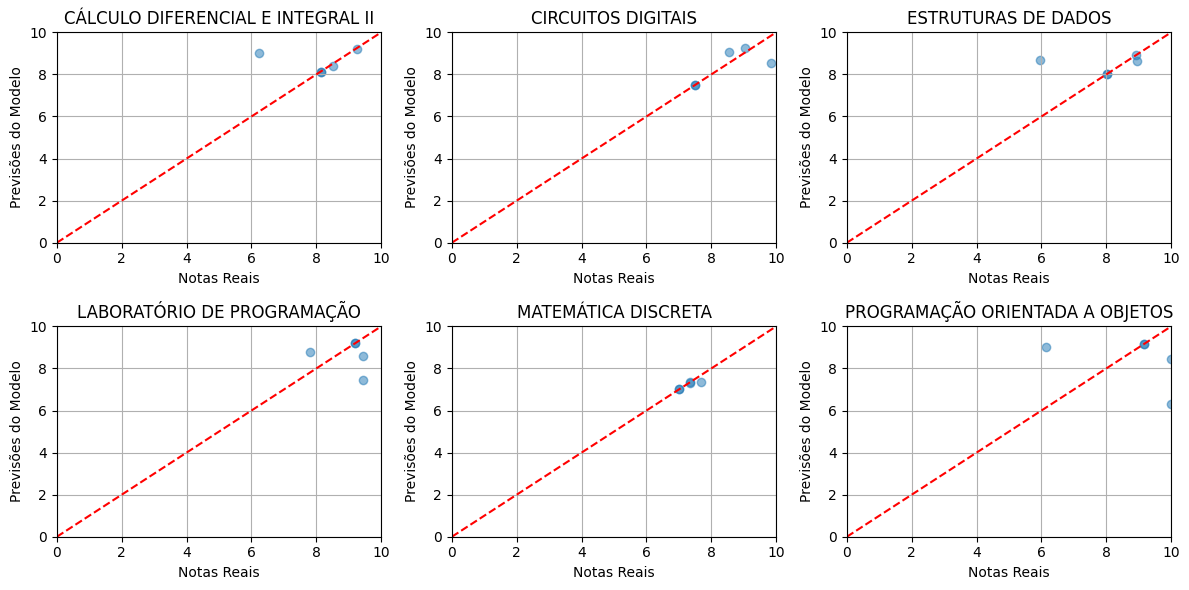

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, disciplina in enumerate(y.columns):
    plt.subplot(2, 3, i + 1)
    plt.scatter(y_test[disciplina], y_pred[:, i], alpha=0.5)
    plt.title(disciplina)
    plt.xlabel('Notas Reais')
    plt.ylabel('Previsões do Modelo')
    plt.plot([0, 10], [0, 10], color='red', linestyle='--')
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    plt.grid(True)

plt.tight_layout()  # Adiciona espaço automático entre os subplots
plt.show()


Por fim, vamos analizar o MAE em Cross Validation, ou seja, vamos dividir os dados em 5 partes e treinar o modelo 5 vezes, cada vez usando uma parte diferente dos dados para teste. Isso nos dará uma ideia melhor de como o modelo está se saindo em diferentes partes dos dados. Vamos usar a função `cross_val_score` do scikit-learn para isso.

In [70]:
from sklearn.model_selection import cross_val_score, KFold

# Adiciona o MultiOutputRegressor para lidar com o cross_val_score em múltiplas saídas
model = MultiOutputRegressor(RandomForestRegressor())

# KFold com 5 divisões
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# cross_val_score retorna scores negativos para erro, por isso usamos 'neg_mean_absolute_error'
scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error')

# Como os scores são negativos, inverta o sinal para obter o MAE positivo
mae_scores = -scores

print(f'MAE em cada fold: {mae_scores}')
print(f'MAE médio: {mae_scores.mean():.2f}')

MAE em cada fold: [0.65845556 0.65375556 0.06177778 0.44354167 0.41880556]
MAE médio: 0.45


Como podemos observar, o MAE médio em Cross Validation é de apenas 0.45, o que é um resultado excelente. Isso significa que o modelo está prevendo as notas com uma diferença média de apenas 0.45 pontos em diferentes partes dos dados.

Agora, vamos criar um modelo para cade período e fazer o MAE em Cross Validation.

In [71]:
# Notas dos períodos passados
X_list = [
    P1,
    P1 + P2,
    P1 + P2 + P3,
    P1 + P2 + P3 + P4,
    P1 + P2 + P3 + P4 + P5,
    P1 + P2 + P3 + P4 + P5 + P6,
]
# Notas dos períodos futuros
y_list = [
    P2,
    P3,
    P4,
    P5,
    P6,
    P7,
]

# Lista para armazenar os MAEs de cada período
mae_results = []

for i in range(len(X_list)):
    X = df[X_list[i]]
    y = df[y_list[i]]

    dados = pd.concat([X, y], axis=1).dropna()
    X = dados[X.columns]
    y = dados[y.columns]

    # Adiciona o MultiOutputRegressor para lidar com o cross_val_score em múltiplas saídas
    model = MultiOutputRegressor(RandomForestRegressor())

    # Calcula os scores usando cross_val_score
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error')

    # Inverte o sinal dos scores para obter o MAE positivo
    mae_scores = -scores

    # Armazena os resultados
    mae_results.append(mae_scores.mean())

print("MAE médio para cada período:")
for i, mae in enumerate(mae_results):
    print(f"Modelo que preve o período {i + 2}: {mae:.2f}")

MAE médio para cada período:
Modelo que preve o período 2: 0.44
Modelo que preve o período 3: 0.69
Modelo que preve o período 4: 0.40
Modelo que preve o período 5: 0.49
Modelo que preve o período 6: 0.40
Modelo que preve o período 7: 0.34


Como podemos ver, o MAE médio em Cross Validation para cada período é de apenas 0.34 até 0.69, o que é um resultado excelente. Isso significa que o modelo está prevendo as notas com uma diferença média muito baixa.